In [13]:
# --- 1. Imports & Setup ---
import subprocess
import sys
import os
import warnings
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup

# Install missing packages
def install_if_missing(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

for pkg in ['transformers', 'openpyxl', 'tqdm']:
    install_if_missing(pkg)

warnings.filterwarnings('ignore')

# Set Seeds for Reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Configuration
CONFIG = {
    'batch_size': 16 if torch.cuda.is_available() else 8,
    'max_length': 512,
    'learning_rate': 2e-5,
    'num_epochs': 3,
    'test_split': 0.2,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    # Auto-detect file path for Kaggle or Local
    'file_path': '/kaggle/input/csic_database.csv' if os.path.exists('/kaggle/input') else 'csic_database.xlsx',
    'output_dir': '/kaggle/working' if os.path.exists('/kaggle/input') else './'
}

print(f"Running on device: {CONFIG['device']}")
print(f"Config: {CONFIG}")

Running on device: cuda
Config: {'batch_size': 16, 'max_length': 512, 'learning_rate': 2e-05, 'num_epochs': 3, 'test_split': 0.2, 'device': device(type='cuda'), 'file_path': '/kaggle/input/csic_database.csv', 'output_dir': '/kaggle/working'}


In [14]:
# --- 1. Load & Preprocess: Separate Labels vs Features ---
def load_and_preprocess_cross_attn(file_path):
    # Check if the file exists locally, if not, try standard Kaggle paths
    if not os.path.exists(file_path):
        # Common Kaggle/Colab path fallback
        potential_paths = [
            '/kaggle/input/csic-2010-web-application-attacks/csic_database.csv',
            '/kaggle/input/csic-database/csic_database.csv',
            'csic_database.csv'
        ]
        for p in potential_paths:
            if os.path.exists(p):
                file_path = p
                break

    print(f"Loading: {file_path}")
    
    if file_path.endswith('.csv'): 
        df = pd.read_csv(file_path)
    else: 
        df = pd.read_excel(file_path)
    
    # 1. Standardize Names
    df.columns = [c.lower().strip() for c in df.columns]
    
    # 2. Identify and Remove the Label Column
    possible_labels = ['classification', 'label', 'class', 'target', 'anomalous']
    label_col = next((c for c in possible_labels if c in df.columns), None)
    
    if not label_col:
        raise ValueError("Could not find a label column (e.g., 'classification' or 'label')")
    
    print(f"Found Label Column: '{label_col}'")
    
    # Encode Labels (e.g., 'Normal' -> 0, 'Anomalous' -> 1)
    le = LabelEncoder()
    y = le.fit_transform(df[label_col].astype(str))
    print(f"Encoded Classes: {le.classes_}")
    
    # 3. Identify Feature Columns (The 8 Text Columns)
    # We strictly EXCLUDE the label_col from this list
    all_text_cols = ['method', 'user-agent', 'url', 'content-type', 'payload', 'body', 'data', 'cookie', 'host', 'accept']
    feature_cols = [c for c in df.columns if (c in all_text_cols or 'content' in c) and c != label_col]
    
    print(f"Feature Columns (Inputs): {feature_cols}")
    
    # Fill NaNs in features
    for col in feature_cols:
        df[col] = df[col].astype(str).fillna("empty")
        
    return df[feature_cols], y, le, feature_cols

# --- Execute with the specific filename ---
# We pass the filename directly here as requested
df_features, labels, label_encoder, feature_names = load_and_preprocess_cross_attn('csic_database.csv')

Loading: /kaggle/input/csic-2010-web-application-attacks/csic_database.csv
Found Label Column: 'classification'
Encoded Classes: ['0' '1']
Feature Columns (Inputs): ['method', 'user-agent', 'accept', 'host', 'cookie', 'content-type', 'content', 'url']


In [15]:
# --- 2. Multi-Column Tokenization & Dataset ---
print("Tokenizing independent columns...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Dictionary to store tokenized data for each column
column_encodings = {}

# We limit max_length per column to 64. 
# 8 columns * 64 tokens = 512 total tokens (Standard BERT size), so this fits in memory.
COL_MAX_LEN = 64 

for col in feature_names:
    print(f"Tokenizing {col}...")
    column_encodings[col] = tokenizer(
        df_features[col].tolist(),
        padding='max_length',
        truncation=True,
        max_length=COL_MAX_LEN,
        return_tensors="pt"
    )

class CrossAttnDataset(Dataset):
    def __init__(self, encodings_dict, labels, feature_names):
        self.encodings = encodings_dict
        self.labels = labels
        self.feature_names = feature_names

    def __getitem__(self, idx):
        item = {}
        # Pack every column's data into the item dictionary
        for col in self.feature_names:
            item[f'{col}_input_ids'] = self.encodings[col]['input_ids'][idx]
            item[f'{col}_attention_mask'] = self.encodings[col]['attention_mask'][idx]
        
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Build Dataset
full_dataset = CrossAttnDataset(column_encodings, labels, feature_names)

# Split Data (80% Train, 10% Val, 10% Test)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(
    full_dataset, 
    [train_size, val_size, test_size], 
    generator=torch.Generator().manual_seed(42)
)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=CONFIG['batch_size'])
test_loader = DataLoader(test_ds, batch_size=CONFIG['batch_size'])

print(f"Data Split -> Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")

Tokenizing independent columns...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizing method...
Tokenizing user-agent...
Tokenizing accept...
Tokenizing host...
Tokenizing cookie...
Tokenizing content-type...
Tokenizing content...
Tokenizing url...
Data Split -> Train: 48852 | Val: 6106 | Test: 6107


In [16]:
# --- 3. Cross-Attention Model Architecture ---
class CrossAttentionBert(nn.Module):
    def __init__(self, feature_names, n_classes):
        super().__init__()
        self.feature_names = feature_names
        
        # 1. The Shared Encoder (The eyes)
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bert_hidden_size = 768
        
        # 2. The Inspector (The Query Vector) - LEARNABLE PARAMETER
        # Initialized randomly, it learns what an anomaly "looks like"
        # Shape: [1, 1, 768]
        self.inspector_query = nn.Parameter(torch.randn(1, 1, self.bert_hidden_size))
        
        # 3. Cross Attention Layer
        # Query = Inspector, Key/Value = Column Embeddings
        self.cross_attn = nn.MultiheadAttention(embed_dim=self.bert_hidden_size, num_heads=4, batch_first=True)
        
        # 4. Final Classifier
        self.drop = nn.Dropout(0.3)
        self.supreme_head = nn.Linear(self.bert_hidden_size, n_classes)

    def forward(self, batch_data):
        # A. Extract Embeddings for each column (The Witnesses)
        embeddings = []
        for col in self.feature_names:
            input_ids = batch_data[f'{col}_input_ids'].to(self.bert.device)
            mask = batch_data[f'{col}_attention_mask'].to(self.bert.device)
            
            # Pass through BERT
            out = self.bert(input_ids=input_ids, attention_mask=mask)
            # We take the [CLS] token pooling for each column
            embeddings.append(out.pooler_output)
            
        # Stack them: Shape [Batch, Num_Cols(8), 768]
        witnesses = torch.stack(embeddings, dim=1)
        
        # B. Prepare the Inspector (Query)
        # Expand the single query parameter to match the batch size
        batch_size = witnesses.size(0)
        query = self.inspector_query.expand(batch_size, -1, -1)
        
        # C. Perform Cross Attention
        # The Inspector (Query) looks at the Witnesses (Key/Value)
        # attn_output: The weighted sum of suspicious columns
        # attn_weights: The score (importance) of each column (Explainability!)
        attn_output, attn_weights = self.cross_attn(query, witnesses, witnesses)
        
        # D. Classify
        # Remove the sequence dimension (1) -> [Batch, 768]
        final_vector = attn_output.squeeze(1) 
        logits = self.supreme_head(self.drop(final_vector))
        
        return logits, attn_weights

# Initialize Model
device = CONFIG['device']
model = CrossAttentionBert(feature_names, len(label_encoder.classes_))
model = model.to(device)
print("Cross-Attention Inspector Model Initialized!")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Cross-Attention Inspector Model Initialized!


In [17]:
# --- 4. Training Loop ---
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

print(f"Starting Training for {CONFIG['num_epochs']} epochs...")

for epoch in range(CONFIG['num_epochs']):
    model.train()
    total_loss = 0
    correct_preds = 0
    total_preds = 0
    
    # Progress bar for the epoch
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for batch in loop:
        labels = batch['labels'].to(device)
        
        # Forward Pass
        logits, _ = model(batch) 
        
        loss = loss_fn(logits, labels)
        total_loss += loss.item()
        
        # Calculate Accuracy for progress bar
        _, preds = torch.max(logits, dim=1)
        correct_preds += torch.sum(preds == labels)
        total_preds += labels.size(0)
        
        # Backward Pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()
        
        # Update progress bar
        loop.set_postfix(loss=loss.item(), acc=(correct_preds/total_preds).item())
        
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} Completed | Avg Loss: {avg_loss:.4f}")

# Save the Inspector Model
torch.save(model.state_dict(), 'inspector_waap_model.pt')
print("Model Saved as 'inspector_waap_model.pt'")

Starting Training for 3 epochs...


Epoch 1:   0%|          | 0/3054 [00:00<?, ?it/s]

Epoch 1 Completed | Avg Loss: 0.1656


Epoch 2:   0%|          | 0/3054 [00:00<?, ?it/s]

Epoch 2 Completed | Avg Loss: 0.1052


Epoch 3:   0%|          | 0/3054 [00:00<?, ?it/s]

Epoch 3 Completed | Avg Loss: 0.0853
Model Saved as 'inspector_waap_model.pt'



--- Final Evaluation & Explainability ---


Testing:   0%|          | 0/382 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3614
           1       0.99      0.92      0.95      2493

    accuracy                           0.96      6107
   macro avg       0.97      0.96      0.96      6107
weighted avg       0.96      0.96      0.96      6107


--- Inspector Logic Analysis (Attention Weights) ---
Analyzed Request #0
Prediction: 1 | Actual: 1
Inspector Focus (Higher score = More Suspicious):
Column          | Attention Score
-----------------------------------
method          | 0.0255
user-agent      | 0.0331
accept          | 0.0024
host            | 0.0085
cookie          | 0.0294
content-type    | 0.0086
content         | 0.8529
url             | 0.0395


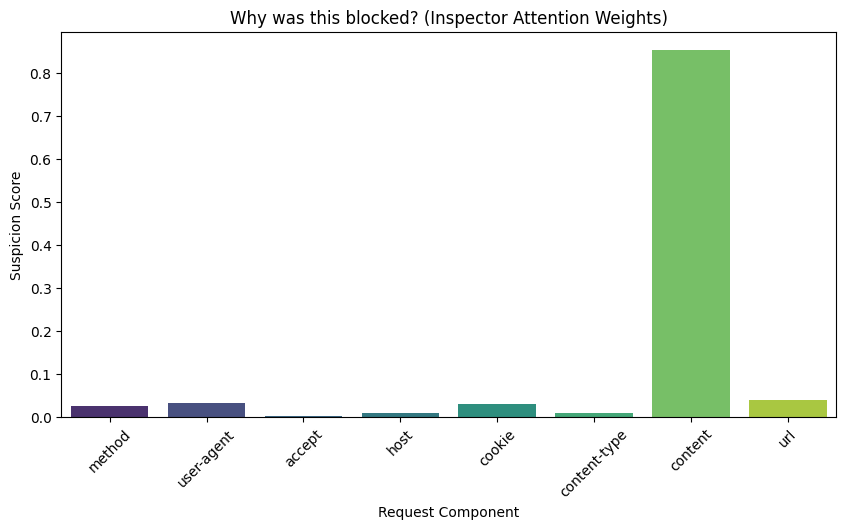

In [18]:
# --- 5. Evaluation & Explainability Check ---
model.eval()
print("\n--- Final Evaluation & Explainability ---")

all_preds = []
all_labels = []

# 1. Calculate Metrics
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        labels = batch['labels'].to(device)
        logits, _ = model(batch)
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# 2. Visualize Explainability (Why did it block?)
# We take one ANOMALOUS example to see what the Inspector looked at
print("\n--- Inspector Logic Analysis (Attention Weights) ---")

with torch.no_grad():
    # Grab a batch
    sample_batch = next(iter(test_loader))
    logits, attn_weights = model(sample_batch)
    preds = torch.argmax(logits, dim=1)
    
    # Find the first index that was predicted as "Anomalous" (assuming Anomalous is index 1 or similar)
    # If your classes are ['Normal', 'Anomalous'], index might be 0 or 1.
    target_idx = -1
    for i, p in enumerate(preds):
        if p.item() == 1: # Assuming 1 is Anomalous/Attack
            target_idx = i
            break
            
    if target_idx != -1:
        idx = target_idx
        pred_label = label_encoder.inverse_transform([preds[idx].item()])[0]
        actual_label = label_encoder.inverse_transform([sample_batch['labels'][idx].item()])[0]
        
        # Get attention weights for this specific request
        weights = attn_weights[idx, 0, :].cpu().numpy()
        
        print(f"Analyzed Request #{idx}")
        print(f"Prediction: {pred_label} | Actual: {actual_label}")
        print("Inspector Focus (Higher score = More Suspicious):")
        
        # Print table
        print(f"{'Column':<15} | {'Attention Score':<15}")
        print("-" * 35)
        for col, weight in zip(feature_names, weights):
            print(f"{col:<15} | {weight:.4f}")
            
        # Plot
        plt.figure(figsize=(10, 5))
        sns.barplot(x=feature_names, y=weights, palette="viridis")
        plt.title(f"Why was this blocked? (Inspector Attention Weights)")
        plt.ylabel("Suspicion Score")
        plt.xlabel("Request Component")
        plt.xticks(rotation=45)
        plt.show()
    else:
        print("No anomalous predictions found in this batch to visualize.")

In [19]:
# --- Save Model to Kaggle Working Directory ---
import os

# Define the path
save_path = '/kaggle/working/best_student_waf_model.pt'

# Create the save dictionary
# We save the model weights + the metadata needed to run it (feature names, classes)
model_artifacts = {
    'model_state_dict': model.state_dict(),
    'feature_names': feature_names,          # Critical: The list of 8 columns used
    'class_names': label_encoder.classes_,   # Critical: What 0 and 1 mean
    'config': CONFIG,
    'input_max_length': 64                   # The length used during tokenization
}

# Save
torch.save(model_artifacts, save_path)

print(f"✅ Model successfully saved to: {save_path}")
print("You can now go to the 'Output' tab of your Kaggle notebook to download it.")

✅ Model successfully saved to: /kaggle/working/best_student_waf_model.pt
You can now go to the 'Output' tab of your Kaggle notebook to download it.


In [28]:
# Updated Class to support smaller Backbones
class CrossAttentionBert(nn.Module):
    def __init__(self, feature_names, n_classes, model_name='bert-base-uncased'):
        super().__init__()
        self.feature_names = feature_names
        
        # Load the specific backbone (Base, Small, or Mini)
        self.bert = BertModel.from_pretrained(model_name)
        
        # AUTO-DETECT Hidden Size (Crucial for smaller models)
        # bert-base = 768, bert-small = 512, bert-mini = 256
        self.bert_hidden_size = self.bert.config.hidden_size 
        
        # Update components to match the detected size
        self.inspector_query = nn.Parameter(torch.randn(1, 1, self.bert_hidden_size))
        self.cross_attn = nn.MultiheadAttention(embed_dim=self.bert_hidden_size, num_heads=4, batch_first=True)
        self.drop = nn.Dropout(0.3)
        self.supreme_head = nn.Linear(self.bert_hidden_size, n_classes)

    def forward(self, batch_data):
        embeddings = []
        for col in self.feature_names:
            input_ids = batch_data[f'{col}_input_ids'].to(self.bert.device)
            mask = batch_data[f'{col}_attention_mask'].to(self.bert.device)
            out = self.bert(input_ids=input_ids, attention_mask=mask)
            embeddings.append(out.pooler_output)
            
        witnesses = torch.stack(embeddings, dim=1)
        batch_size = witnesses.size(0)
        query = self.inspector_query.expand(batch_size, -1, -1)
        
        attn_output, attn_weights = self.cross_attn(query, witnesses, witnesses)
        final_vector = attn_output.squeeze(1) 
        logits = self.supreme_head(self.drop(final_vector))
        
        return logits, attn_weights

In [29]:
import torch.nn.functional as F

# --- 1. Load TEACHER (Your big model) ---
teacher = CrossAttentionBert(feature_names, len(label_encoder.classes_), 'bert-base-uncased')

# FIX: Add weights_only=False to allow loading the config and numpy arrays
checkpoint = torch.load('/kaggle/working/best_student_waf_model.pt', weights_only=False)

teacher.load_state_dict(checkpoint['model_state_dict'])
teacher.to(device)
teacher.eval() # Freeze teacher

# --- 2. Create STUDENT (Small model) ---
# We use a smaller pre-trained BERT
student = CrossAttentionBert(feature_names, len(label_encoder.classes_), 'prajjwal1/bert-small')
student.to(device)
student.train()

# --- 3. Setup Distillation Training ---
optimizer = torch.optim.AdamW(student.parameters(), lr=5e-5)
hard_loss_fn = nn.CrossEntropyLoss()
soft_loss_fn = nn.KLDivLoss(reduction="batchmean")

temperature = 4.0   # Softens probabilities to reveal details
alpha = 0.5         # Balance: 50% learn from Teacher, 50% learn from Truth

print("🎓 Starting Distillation: Big Model -> Small Model")

for epoch in range(3): 
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Distilling Epoch {epoch+1}"):
        # Move batch to device
        labels = batch['labels'].to(device)
        
        # --- A. Get Teacher Predictions (No Grad) ---
        with torch.no_grad():
            teacher_logits, _ = teacher(batch)
        
        # --- B. Get Student Predictions (With Grad) ---
        student_logits, _ = student(batch)
        
        # --- C. Calculate Distillation Loss ---
        # 1. Hard Loss (Student vs Real Label)
        loss_hard = hard_loss_fn(student_logits, labels)
        
        # 2. Soft Loss (Student vs Teacher)
        teacher_probs = F.softmax(teacher_logits / temperature, dim=1)
        student_log_probs = F.log_softmax(student_logits / temperature, dim=1)
        loss_soft = soft_loss_fn(student_log_probs, teacher_probs) * (temperature ** 2)
        
        # Combine
        loss = (alpha * loss_soft) + ((1 - alpha) * loss_hard)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader)}")

# Save the Small Student
torch.save(student.state_dict(), 'small_waap_student.pt')
print("✅ Distillation Complete! Model size should be significantly smaller.")

config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/116M [00:00<?, ?B/s]

🎓 Starting Distillation: Big Model -> Small Model


Distilling Epoch 1:   0%|          | 0/3054 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/116M [00:00<?, ?B/s]

Epoch 1 Loss: 0.3012009862387329


Distilling Epoch 2:   0%|          | 0/3054 [00:00<?, ?it/s]

Epoch 2 Loss: 0.12945801965148537


Distilling Epoch 3:   0%|          | 0/3054 [00:00<?, ?it/s]

Epoch 3 Loss: 0.10194256581749463
✅ Distillation Complete! Model size should be significantly smaller.


In [30]:
# Use this AFTER training your current model
import torch.quantization

# 1. Switch to CPU (Quantization is best supported on CPU for deployment)
model.to('cpu')
model.eval()

# 2. Apply Dynamic Quantization
quantized_model = torch.quantization.quantize_dynamic(
    model, 
    {torch.nn.Linear},  # Quantize the heavy Linear layers inside BERT
    dtype=torch.qint8
)

# 3. Save
torch.save(quantized_model.state_dict(), 'quantized_waf_model.pt')
print("Quantized model saved! (Check file size, it will be tiny)")

Quantized model saved! (Check file size, it will be tiny)


In [31]:
# --- 1. Evaluate the Student Model ---
print("\n--- 📊 Evaluating Student Model Performance ---")
student.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing Student"):
        labels = batch['labels'].to(device)
        input_ids = batch
        
        # Get predictions
        logits, _ = student(batch)
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print Results
print("\nClassification Report (Student Model):")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Calculate Accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"✅ Student Model Accuracy: {acc*100:.2f}%")

# --- 2. Save the Student Model ---
save_path = '/kaggle/working/best_student_waap_model.pt'

model_artifacts = {
    'model_state_dict': student.state_dict(),
    'feature_names': feature_names,
    'class_names': label_encoder.classes_,
    'config': CONFIG,
    'input_max_length': 64,
    'architecture': 'bert-small' # Tagging it as the small version
}

torch.save(model_artifacts, save_path)

print(f"\n💾 Model saved to: {save_path}")
print("You can now download 'best_student_waap_model.pt' from the Output tab.")


--- 📊 Evaluating Student Model Performance ---


Testing Student:   0%|          | 0/382 [00:00<?, ?it/s]


Classification Report (Student Model):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3614
           1       0.98      0.94      0.96      2493

    accuracy                           0.97      6107
   macro avg       0.97      0.96      0.97      6107
weighted avg       0.97      0.97      0.97      6107

✅ Student Model Accuracy: 96.68%

💾 Model saved to: /kaggle/working/best_student_waap_model.pt
You can now download 'best_student_waap_model.pt' from the Output tab.


In [34]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

# --- 1. Define the Prediction Logic ---
def run_dataset_aligned_prediction(b):
    """
    Takes input from the 8 specific dataset widgets, runs the model, and plots the result.
    """
    # Clear previous output
    with output_box:
        clear_output()
        print("🔍 Scanning request against CSIC Dataset Schema...")
        
        # 1. Gather Input Data (Mapping widgets to exact column names)
        # keys must match 'feature_names' from your training (lowercase)
        request_data = {
            'method': method_input.value,
            'url': url_input.value,
            'user-agent': ua_input.value,
            'content-type': ctype_input.value,
            'cookie': cookie_input.value,
            'accept': accept_input.value,
            'host': host_input.value,
            'content': content_input.value 
        }

        # 2. Tokenize & Batch
        input_batch = {}
        try:
            # We loop through the feature_names list saved in your model
            # This ensures we don't miss any column or add extra ones
            for feature in feature_names:
                
                # Get value from our form, default to "empty" if missing
                val = request_data.get(feature, "empty")
                
                # Tokenize
                encoded = tokenizer(
                    str(val),
                    padding='max_length', 
                    truncation=True, 
                    max_length=64, # Must match training max_length
                    return_tensors="pt"
                )
                
                input_batch[f'{feature}_input_ids'] = encoded['input_ids'].to(device)
                input_batch[f'{feature}_attention_mask'] = encoded['attention_mask'].to(device)
            
            # 3. Model Inference
            model.eval()
            with torch.no_grad():
                logits, attn_weights = model(input_batch)
                probs = F.softmax(logits, dim=1)
                pred_idx = torch.argmax(logits, dim=1).item()
                
                # Get labels
                pred_label = label_encoder.inverse_transform([pred_idx])[0]
                
                # Dynamic anomaly score retrieval
                # We find the index of the "Anomalous" or "1" class
                anomaly_idx = 1
                if 'Anomalous' in label_encoder.classes_:
                    anomaly_idx = list(label_encoder.classes_).index('Anomalous')
                elif '1' in label_encoder.classes_: # If labels are 0/1 strings
                     anomaly_idx = list(label_encoder.classes_).index('1')
                     
                anomaly_score = probs[0][anomaly_idx].item()
            
            # 4. Display Text Results
            print(f"\n--- 🛡️ WAAP PREDICTION RESULT ---")
            print(f"Prediction: {str(pred_label).upper()}")
            print(f"Anomaly Score: {anomaly_score:.4f}  (Block Threshold: 0.95)")
            
            if anomaly_score > 0.95:
                print("⛔ STATUS: BLOCKED (High Confidence)")
            elif anomaly_score > 0.50:
                print("⚠️ STATUS: REVIEW (Ambiguous)")
            else:
                print("✅ STATUS: ALLOWED (Normal)")

            # 5. Visualize "Inspector" Attention
            # Shows which of the 8 columns contributed most to the decision
            weights = attn_weights[0, 0, :].cpu().numpy()
            
            plt.figure(figsize=(10, 4))
            # Color logic: Red if weight is high (suspicious), Blue if low
            colors = ['#d32f2f' if w > 0.2 else '#1976d2' for w in weights] 
            
            sns.barplot(x=feature_names, y=weights, palette=colors)
            plt.title(f"Inspector Focus: Which column triggered the Model?")
            plt.ylabel("Attention Weight")
            plt.xlabel("Dataset Columns")
            plt.xticks(rotation=45)
            plt.show()
            
        except Exception as e:
            print(f"❌ Error during inference: {str(e)}")
            print("Debug Hint: Ensure 'feature_names' list matches the dictionary keys above.")

# --- 2. Create UI Widgets for the 8 Dataset Columns ---

style = {'description_width': '120px'}
layout_full = widgets.Layout(width='95%')
layout_half = widgets.Layout(width='47%')

# 1. Method
method_input = widgets.Dropdown(
    options=['GET', 'POST', 'PUT', 'DELETE', 'OPTIONS', 'HEAD'],
    value='GET',
    description='Method:',
    style=style, layout=layout_half
)

# 2. URL
url_input = widgets.Text(
    value='http://localhost:8080/tienda1/publico/anadir.jsp?id=2&nombre=Jamon+Iberico',
    placeholder='Full URL or Path',
    description='URL:',
    style=style, layout=layout_full
)

# 3. Content (Payload)
content_input = widgets.Textarea(
    value='',
    placeholder='id=2&nombre=Jamon+Iberico&precio=85',
    description='Content (Body):',
    style=style, layout=widgets.Layout(width='95%', height='80px')
)

# 4. User-Agent
ua_input = widgets.Text(
    value='Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.8 (like Gecko)',
    description='User-Agent:',
    style=style, layout=layout_full
)

# 5. Content-Type
ctype_input = widgets.Text(
    value='application/x-www-form-urlencoded',
    description='Content-Type:',
    style=style, layout=layout_half
)

# 6. Cookie
cookie_input = widgets.Text(
    value='JSESSIONID=1F767F1E2390A92F32',
    description='Cookie:',
    style=style, layout=layout_full
)

# 7. Accept
accept_input = widgets.Text(
    value='text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5',
    description='Accept:',
    style=style, layout=layout_full
)

# 8. Host
host_input = widgets.Text(
    value='localhost:8080',
    description='Host:',
    style=style, layout=layout_half
)

run_btn = widgets.Button(
    description='🔍 Analyze Request',
    button_style='success', 
    layout=widgets.Layout(width='100%', margin='20px 0px'),
    icon='shield-alt'
)

# Connect button
run_btn.on_click(run_dataset_aligned_prediction)

# Output area
output_box = widgets.Output()

# --- 3. Construct Layout ---
ui = widgets.VBox([
    widgets.HTML("<h3>🛡️ CSIC 2010 Dataset Model Inspector</h3>"),
    widgets.HTML("<i>Enter values for the 8 columns used in training:</i>"),
    widgets.HBox([method_input, host_input]),
    url_input,
    content_input,
    ua_input,
    widgets.HBox([ctype_input, widgets.Label("")]), # Spacer
    cookie_input,
    accept_input,
    run_btn,
    output_box
])

display(ui)